In [11]:
import os
import pandas as pd
import numpy as np
from grid2 import BuildGridCenters
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import h5py
from xtb_density import interplot_ecloud
from chem import get_center, read_sdf
import shutil
from glob import glob

In [3]:
# Now choose the protocol for your data, size, N, respolution control the grid size
def protocol(mode=32):
    size = mode
    N = [size, size, size]
    if mode == 32:
        resolution = 0.5
        llc = (np.zeros(3) - float(size * resolution / 2)) + resolution / 2
        grids = BuildGridCenters(llc, N, resolution)
    elif mode == 64:
        resolution = 0.2
        llc = (np.zeros(3) - float(size * resolution / 2)) + resolution / 2
        grids = BuildGridCenters(llc, N, resolution)
    
    return {'grids':grids, 'N':N}

def get_ligecloud(mol,calculater, protocol, add_noise=True):
    '''
    Input:
        mol: rdkit 3D mol
        calculater: xtb density calculater
        protocol: protocol for the grid, format: {'grids':(32, 32, 32, 3), 'N':[32, 32, 32]}
        add_noise: add noise to the ligand grid
    Output:
        lig_density: ligand electron density, shape: (32, 32, 32)
    '''
    stand_grid = protocol['grids']
    N = protocol['N']
    mol_center = mol_center = get_center(mol) 
    lig_grids = stand_grid + mol_center 
    if add_noise:
        lig_grids += np.random.randn(3).astype(np.float32)
    lig_ecloud = calculater.calculate(mol)
    lig_density = interplot_ecloud(lig_ecloud, lig_grids.transpose(3, 0, 1, 2)).reshape(N)
    return lig_density

In [4]:
# load molecule
mol = read_sdf('ligand.sdf')[0]

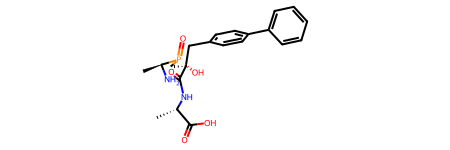

In [5]:
mol

In [14]:
# define calculater
from xtb_density import CDCalculator, interplot_ecloud
calculater = CDCalculator(xtb_command='/home/haotian/Molecule_Generation/MG/ECloudGen_old/xtb-bleed/bin/xtb')
# calculator will create a temp folder

In [15]:
# get ligand electron density easily
lig_density = get_ligecloud(mol,calculater, protocol(32))


In [16]:
lig_density.shape

(32, 32, 32)

In [19]:
# remove the temp folder
temp_dirs = glob('./temp/*')
for temp_dir in temp_dirs:
    shutil.rmtree(temp_dir)
    print(f'{temp_dir} removed')

In [10]:
# save the ligand electron density as npy file
np.save(f'lig_density.npy',lig_density)

In [21]:
import pickle
def read_pkl(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data